In [2]:
import sys
import os
sys.path.append(os.path.join(r'D:\e-commerce_env\e-commerce\Lib\site-packages'))
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv',encoding= 'unicode_escape')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df['StockCode'].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [3]:
def transform_datatypes_and_nulls(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['CustomerID'].fillna(0,inplace=True)
    df['CustomerID'] = df['CustomerID'].astype(int)
    df['Quantity'] = df['Quantity'].astype(int)

def fill_null_values_in_descripctions(df):
    # Sort the DataFrame by 'StockCode' and 'InvoiceDate' to ensure rows with the same 'StockCode' are consecutive
    df.sort_values(by=['StockCode', 'InvoiceDate'], inplace=True)
    # Use forward-fill (ffill) to replace null values in 'Description' column
    df['Description'].fillna(method='ffill', inplace=True)
    
# all transactions which weren't normal orders, rather some fee payments etc.
def divide_uncommon_transactions(df):
    df_M = df[df['StockCode'] == 'M']
    df_DOT = df[df['StockCode'] == 'DOT']
    df_BANK_CHARGES = df[df['StockCode'] == 'BANK CHARGES']
    df_AMAZONFEE = df[df['StockCode'] == 'AMAZONFEE']
    df_BAD_DEBT = df[df['StockCode'] == "B"]
    df_POSTAGE = df[df['StockCode'] == "POST"]
    df_DISCOUNT = df[df['StockCode'] == "D"]
    df_CRUK_COMMISIONS = df[df['StockCode'] == "CRUK"]

    return {
        'M': df_M,
        'DOT': df_DOT,
        'BANK CHARGES': df_BANK_CHARGES,
        'AMAZONFEE': df_AMAZONFEE,
        'B': df_BAD_DEBT,
        'POST': df_POSTAGE,
        'D': df_DISCOUNT,
        'CRUK': df_CRUK_COMMISIONS
    }

def create_filtered_orders(df):
    mask = (df['StockCode'] != "AMAZONFEE") & (df['StockCode'] != "BANK CHARGES") & (df['StockCode'] != "M") & (df['StockCode'] != "DOT") & (df['StockCode'] != "B")& (df['StockCode'] != "POST") & (df['StockCode'] != "D") &(df['StockCode'] != "CRUK")
    filtered_df = df[mask]
    return filtered_df

# checking for all canceled orders 
def cancelled_orders(df):
    mask = df['InvoiceNo'].str.startswith('C')
    cancelled_orders = df[mask]
    return cancelled_orders

#items which are damaged, lost but they are not returns
def items_which_are_not_sellable():
    maska = filtered_df['InvoiceNo'].str.startswith('C')
    not_sellable_items = filtered_df[(maska==False) & (filtered_df['Quantity']<0)]
    return not_sellable_items

def remove_cancelled_lost_and_damaged_orders_from_filtered_df():
    new_df = filtered_df[(filtered_df['Quantity']<0)==False]
    return new_df

def create_df_with_manual_returns():
    df_M_returns = df_M[df_M['Quantity']<0]
    return df_M_returns

def add_full_items_price_to_df(df):
    df['FullPrice'] = df['Quantity'] * df['UnitPrice'] 

def delete_items_which_were_returned(filtered_df):
    matching_columns = ["Quantity", "StockCode", "UnitPrice", "CustomerID"]
    # Merge the dataframes based on the matching columns
    merged_df = filtered_df.merge(cancelled_orders_and_returns[matching_columns], how='left', indicator=True)
    # Filter out the rows that were present in both dataframes (returns)
    filtered_df1 = merged_df[merged_df['_merge'] != 'both']
    # Drop the indicator column
    filtered_df1.drop('_merge', axis=1, inplace=True)
    filtered_df1 = filtered_df1.reset_index(drop=True)
    return filtered_df1

def create_dataframe_with_sales_per_item():
    
    grouped = orders.groupby(['StockCode'])
    items_count = grouped['Quantity'].sum()
    product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
    product_summary = pd.DataFrame({
        'TotalQuantitySold': items_count,
        'TotalPrice': product_total_prices
    }).reset_index()
    stockCode_to_desc = orders.set_index('StockCode')['Description'].to_dict()
    stockCode_to_unitprice = orders.set_index('StockCode')['UnitPrice'].to_dict()
    product_summary['Description'] = product_summary['StockCode'].map(stockCode_to_desc)
    product_summary['UnitPrice'] = product_summary['StockCode'].map(stockCode_to_unitprice)
    return product_summary

def create_orders_by_invoiceNum():
    real_orders = orders.groupby('InvoiceNo')
    countries = list()
    invoices = list()
    quantity = real_orders['Quantity'].sum().values
    diff_items = real_orders["Country"].value_counts().values
    customers_id = []
    datetimes = []
    full_price = orders.groupby('InvoiceNo')['FullPrice'].sum().values
    for lista in real_orders['CustomerID'].value_counts().index:
        customers_id.append(lista[1])
        
    for lista in real_orders['InvoiceDate'].value_counts().index:
        datetimes.append(lista[1])
    
    for InvoiceNo, Country in real_orders['Country'].value_counts().index:
        countries.append(Country)
        invoices.append(InvoiceNo)
    df_real_orders = pd.DataFrame(list(zip(invoices,countries,diff_items,quantity,customers_id,datetimes,full_price)),columns=['InvoiceNo','Country','DiffrentItemsPerOrder','Quantity','CustomerID','InvoiceDate','FullPrice'])
    return df_real_orders


df = pd.read_csv('data.csv',encoding= 'unicode_escape')

transform_datatypes_and_nulls(df)
fill_null_values_in_descripctions(df)
df.sort_values(by=['InvoiceDate','InvoiceNo'],inplace=True)
df = df.reset_index(drop=True)

# Call the function and store the results in a dictionary
category_dataframes = divide_uncommon_transactions(df)

# Access each category's DataFrame
df_M = category_dataframes['M']
df_DOT = category_dataframes['DOT']
df_BANK_CHARGES = category_dataframes['BANK CHARGES']
df_AMAZONFEE = category_dataframes['AMAZONFEE']
df_BAD_DEBT = category_dataframes['B']
df_POSTAGE = category_dataframes['POST']
df_DISCOUNT = category_dataframes['D']
df_CRUK_COMMISIONS = category_dataframes['CRUK']
df_M_returns = create_df_with_manual_returns()
df_M = df_M[df_M['Quantity']>=0]

filtered_df = create_filtered_orders(df)
filtered_df = filtered_df.reset_index(drop=True)

cancelled_orders_and_returns = cancelled_orders(filtered_df)
not_sellable_items = items_which_are_not_sellable()
filtered_df = remove_cancelled_lost_and_damaged_orders_from_filtered_df()

add_full_items_price_to_df(filtered_df)
add_full_items_price_to_df(cancelled_orders_and_returns) 

# using abs() on full price and Quantity, so I'm being able to match it with orders from filtered_df
cancelled_orders_and_returns['FullPrice'] = cancelled_orders_and_returns['FullPrice'].apply(lambda x: abs(x))
cancelled_orders_and_returns['Quantity'] = cancelled_orders_and_returns['Quantity'].apply(lambda x: abs(x))

orders = delete_items_which_were_returned(filtered_df)
# there was still one small m so I moved it to the right place
orders[orders['StockCode']=='m']
df_M.append(orders.iloc[39109])
#dropping 1 result which is MANUAL and 1 anomaly which is just a noise
target_date = pd.to_datetime('2011-12-01')
orders = orders[(orders['UnitPrice']!=0) & (orders['InvoiceDate']<target_date)
               ]
unique_orders = create_orders_by_invoiceNum()
product_summary = create_dataframe_with_sales_per_item()
product_summary.sort_values(by=['TotalPrice'],ascending=False,inplace=True)
most_frequently_sold_items = product_summary.sort_values(by=['TotalQuantitySold'],ascending=False)
top_20_most_frequently_sold_items = most_frequently_sold_items[:20]
top_10_total_amount_items = product_summary[:10]




C:\Users\komputer\AppData\Local\Temp\ipykernel_10744\2409554820.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1.drop('_merge', axis=1, inplace=True)
C:\Users\komputer\AppData\Local\Temp\ipykernel_10744\2409554820.py:150: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_M.append(orders.iloc[39109])
C:\Users\komputer\AppData\Local\Temp\ipykernel_10744\2409554820.py:78: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


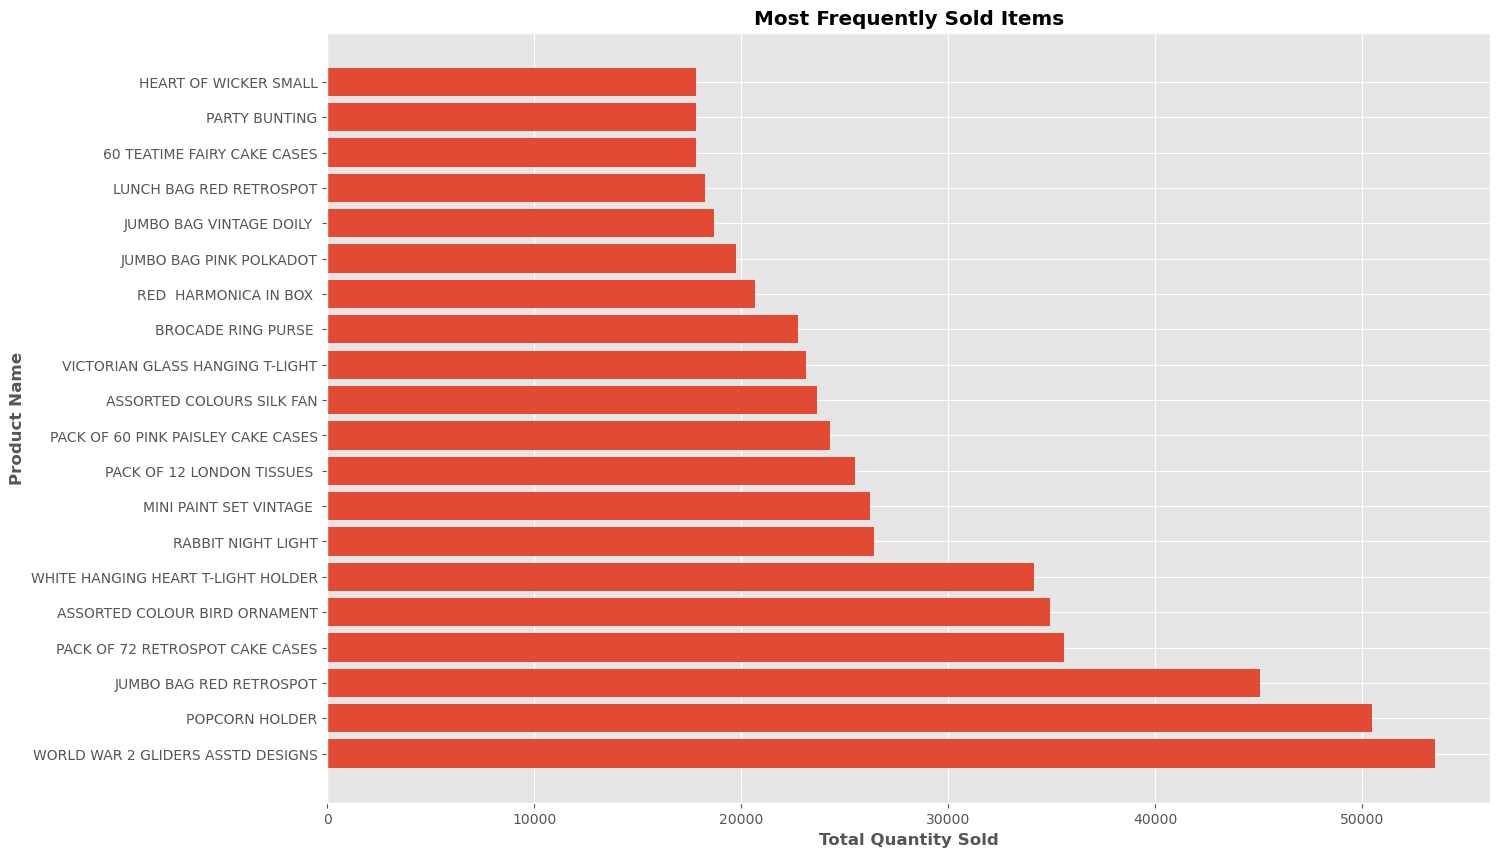

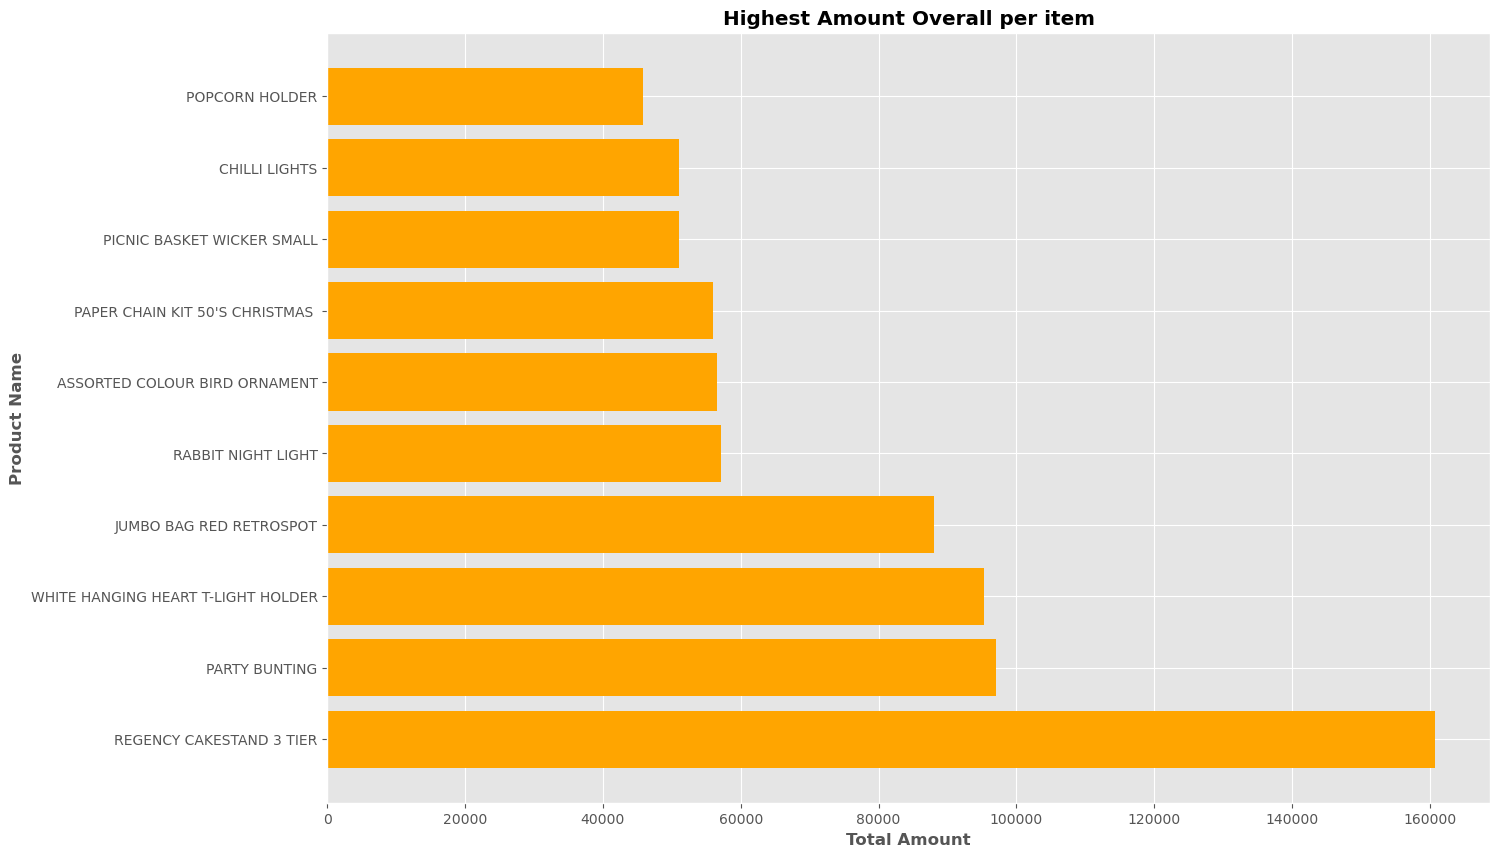

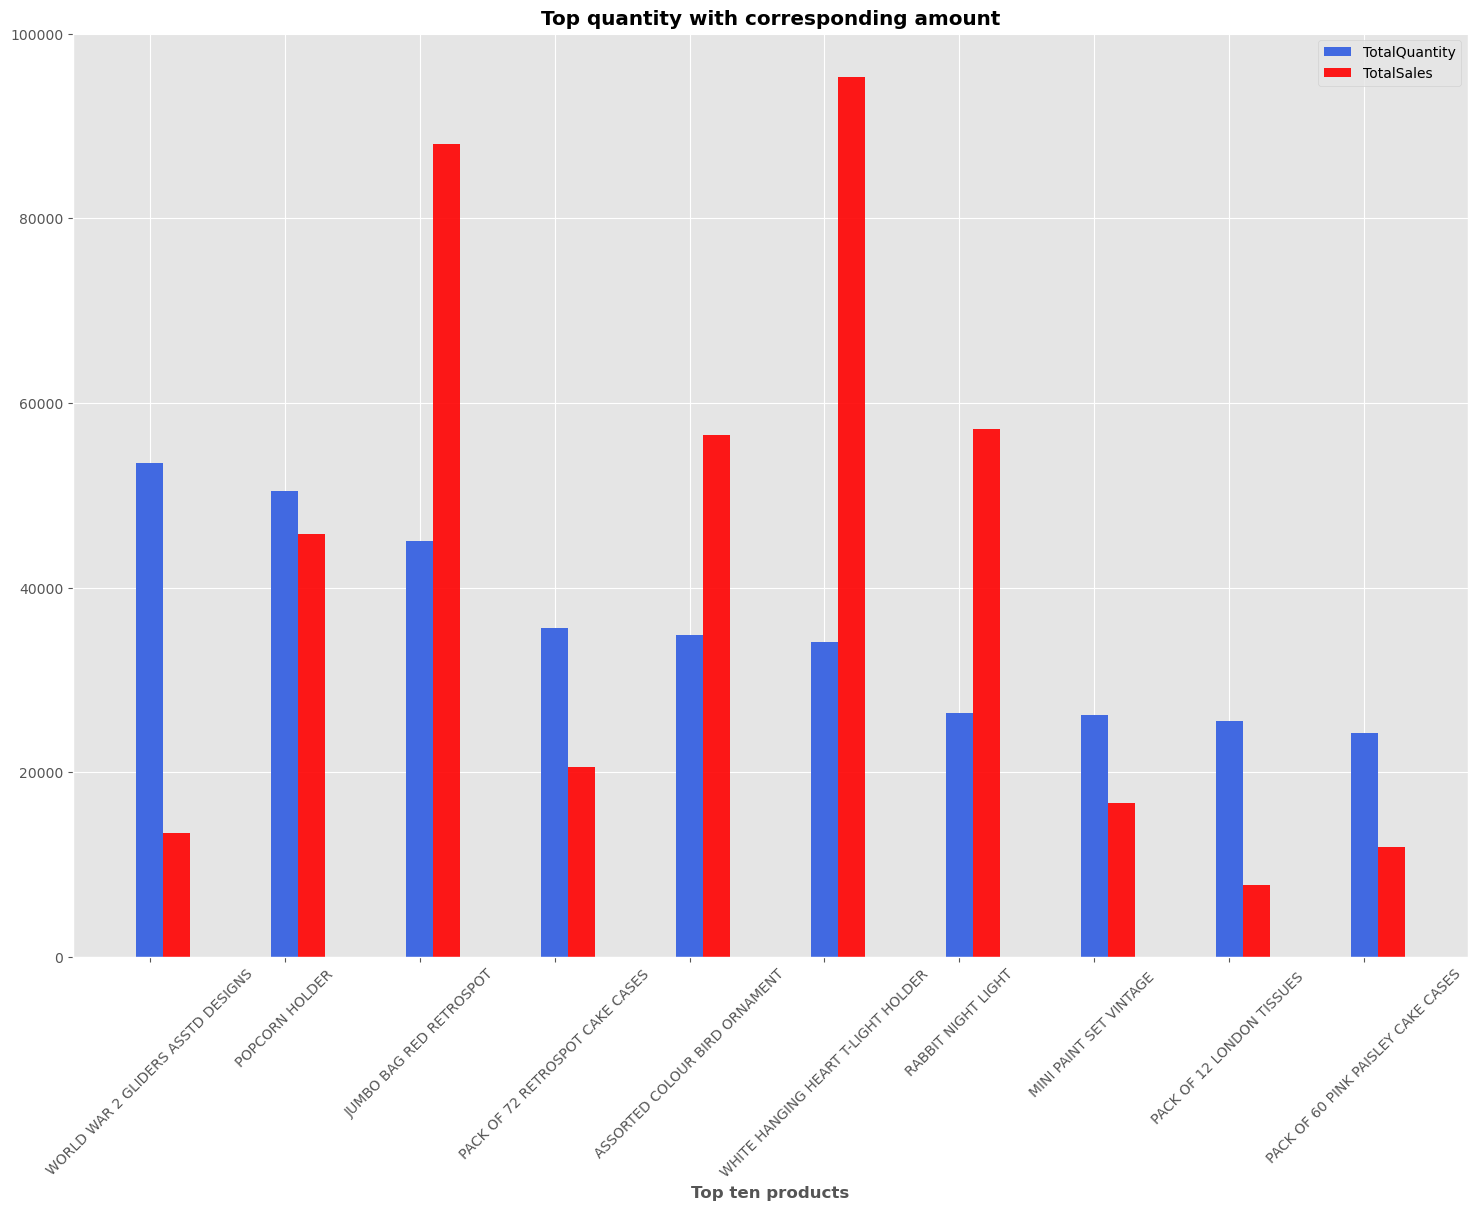

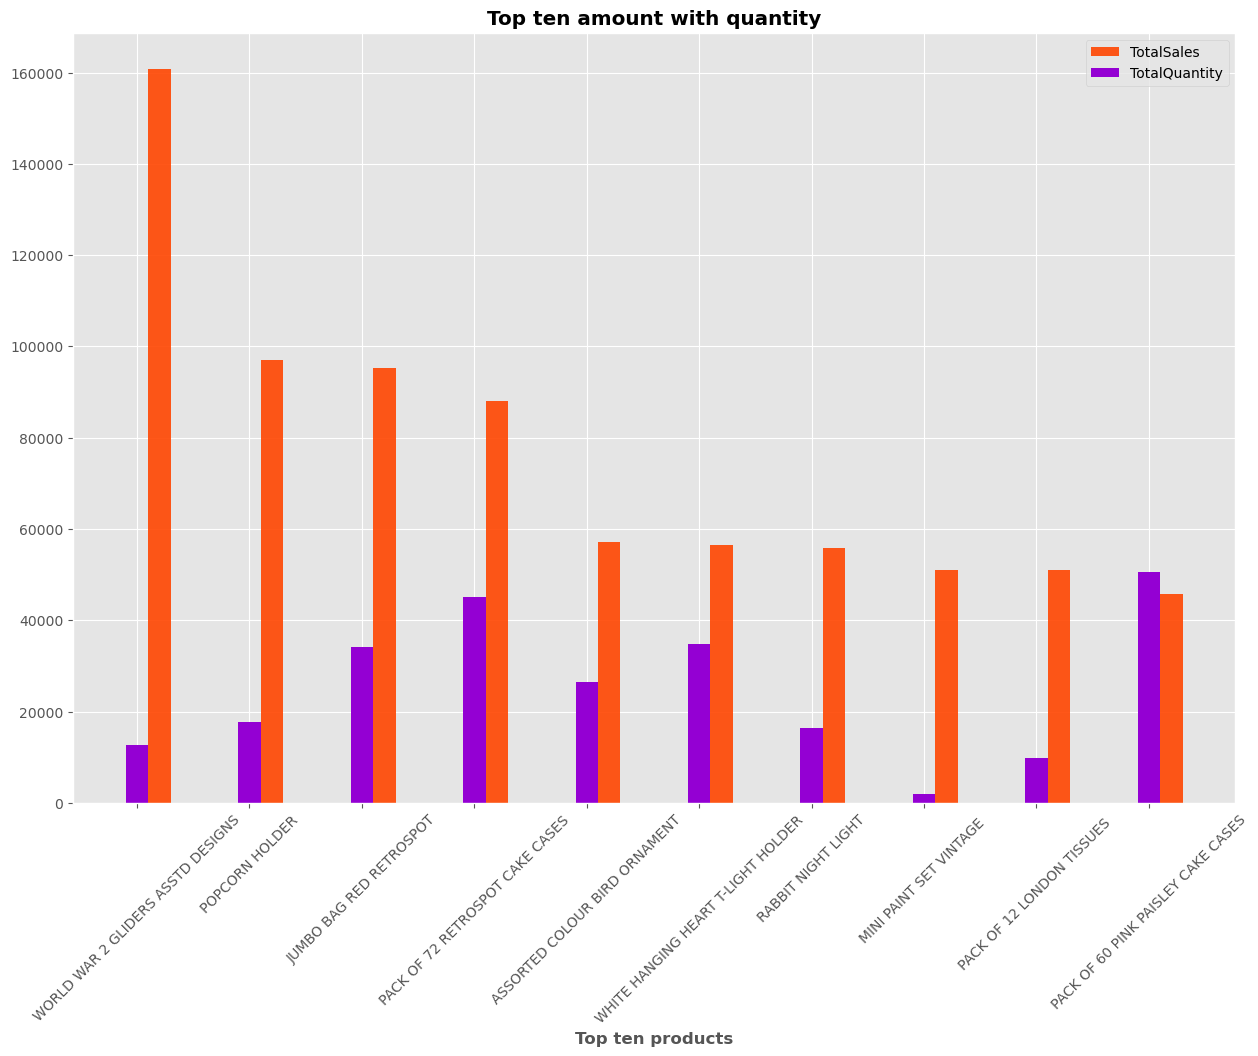

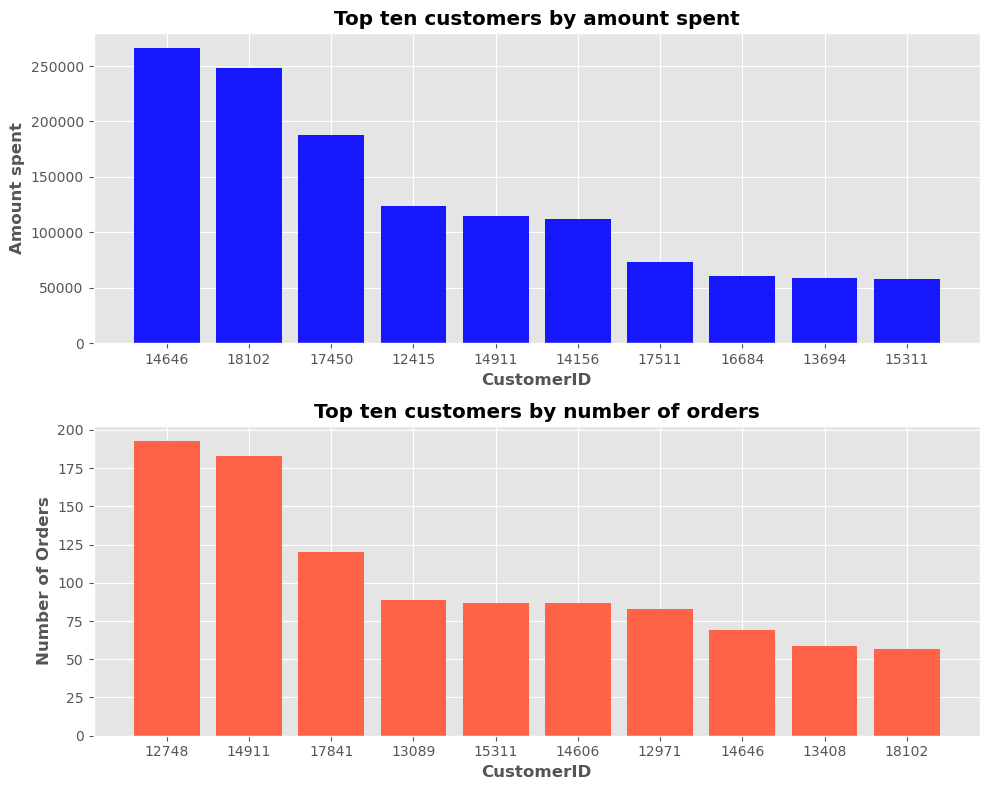

In [10]:
# charts 

 #ITEMS
#top ten quantity
fig = plt.figure(figsize=(15,10))
plt.barh(y=top_20_most_frequently_sold_items["Description"],width=top_20_most_frequently_sold_items["TotalQuantitySold"])
plt.xlabel('Total Quantity Sold',fontweight='bold')
plt.ylabel('Product Name',fontweight='bold')
plt.title('Most Frequently Sold Items',fontweight='bold')
plt.savefig('Most_Freq_Items_Sold.png',bbox_inches='tight')

#top ten total price
fig = plt.figure(figsize=(15,10))
plt.barh(y=top_10_total_amount_items["Description"],width=top_10_total_amount_items["TotalPrice"],color=['orange'])
plt.xlabel('Total Amount',fontweight='bold')
plt.ylabel('Product Name',fontweight='bold')
plt.title('Highest Amount Overall per item',fontweight='bold')
plt.savefig('Items_with_highest_total_price.png',bbox_inches='tight')

#top ten quantity with total_sales
style.use('ggplot')
xpos = np.arange(len(most_frequently_sold_items['Description'][:10]))
barwidth=0.2
plt.figure(figsize=(18,12))
plt.bar(xpos, most_frequently_sold_items['TotalQuantitySold'][:10], width=barwidth,color='royalblue',label='TotalQuantity')
plt.bar(xpos +0.2, most_frequently_sold_items['TotalPrice'][:10],width=barwidth,color='red',label='TotalSales',alpha=0.9)
plt.xticks(xpos,([name for name in most_frequently_sold_items['Description'][:10]]),rotation=45)
plt.title('Top quantity with corresponding amount',fontweight='bold')
plt.legend()
plt.xlabel('Top ten products',fontweight='bold')
plt.savefig('Quantity_with_total_sales.png',bbox_inches='tight')

#top ten amount with quantity
style.use('ggplot')
xpos = np.arange(len(top_10_total_amount_items['Description'][:10]))
barwidth=0.2
plt.figure(figsize=(15,10))
plt.bar(xpos +0.2, top_10_total_amount_items['TotalPrice'][:10],width=barwidth,color='orangered',label='TotalSales',alpha=0.9)
plt.bar(xpos, top_10_total_amount_items['TotalQuantitySold'][:10], width=barwidth,color='darkviolet',label='TotalQuantity')
plt.xticks(xpos,([name for name in most_frequently_sold_items['Description'][:10]]),rotation=45)
plt.title('Top ten amount with quantity',fontweight='bold')
plt.legend()
plt.xlabel('Top ten products',fontweight='bold')
plt.savefig('Top_amount_with_quantity.png',bbox_inches='tight')

# top returned items
return_names = [name for name 
                 in cancelled_orders_and_returns.groupby('Description')['StockCode'].count()
                 .sort_values(ascending=False)[:21].index]
number_of_returns = [value for value in cancelled_orders_and_returns.groupby('Description')['StockCode'].count()
                 .sort_values(ascending=False)[:21].values]
returns_with_names = pd.DataFrame({'Description':return_names,
                                        'NumberOfReturns':number_of_returns})
# deleting samples because they are not returns 
del return_names[3]
del number_of_returns[3]

prices_of_most_returned_items = product_summary[product_summary['Description'].isin(return_names)]
merged_df = prices_of_most_returned_items.merge(returns_with_names,on='Description',how='left')
merged_df = merged_df.sort_values(by='NumberOfReturns',ascending=False)
merged_df = merged_df.reset_index(drop=True).drop(df.index[10])
merged_df

xpos = np.arange(len(returns_with_names['NumberOfReturns'][:15]))
bar_width = 0.2
plt.figure(figsize=(22,8))
plt.bar(xpos,height=merged_df['NumberOfReturns'][:15],color='indigo',width=bar_width,label='Number Of Returns')
plt.bar(xpos+0.2,height=merged_df['TotalQuantitySold'][:15]/100,width=bar_width,label='Hundreds Of Quantity Sold')
plt.xticks(xpos,([name for name in merged_df['Description'][:15]]),rotation=45)
plt.title('Most Often returned items',fontweight='bold')
plt.xlabel('Products Names',fontweight='bold')
plt.ylabel('Number Of Returns',fontweight='bold')
plt.legend()
plt.savefig('Most_often_returned_items.png',bbox_inches='tight')

 #CUSTOMERS
# top ten customers by orders

unique_customers = unique_orders['CustomerID'].value_counts()
top_10_customers_by_orders = unique_orders['CustomerID'].value_counts()[1:11]
values = [str(value) for value in top_10_customers_by_orders.index]

# top ten customers by amount spent
customers_by_amount_spent = unique_orders.groupby('CustomerID')['FullPrice'].sum().sort_values(ascending=False)
top_10_customers_by_amount_spent = customers_by_amount_spent[1:11]
amount_spent_customer_IDs = [str(value) for value in top_10_customers_by_amount_spent.index]

fig, axs = plt.subplots(2,1,figsize=(10,8))
axs[0].bar(x=amount_spent_customer_IDs,height = top_10_customers_by_amount_spent.values,color='blue',alpha=0.9)
axs[0].set_title('Top ten customers by amount spent',fontweight='bold')
axs[0].set_xlabel('CustomerID',fontweight='bold')
axs[0].set_ylabel('Amount spent',fontweight='bold')

axs[1].bar(x=values,height= top_10_customers_by_orders.values,color='tomato')
axs[1].set_title('Top ten customers by number of orders',fontweight='bold')
axs[1].set_xlabel('CustomerID',fontweight='bold')
axs[1].set_ylabel('Number of Orders',fontweight='bold')
plt.tight_layout()

fig.savefig('Top_ten_customers.png')







In [201]:
most_frequently_sold_items['TotalQuantitySold'][:10]

2904    53488
1107    50467
3381    45078
438     35600
3188    34897
3401    34160
1940    26411
1372    26197
1490    25500
928     24283
Name: TotalQuantitySold, dtype: int32

In [113]:
# total sales compared to returns 
sales_minus_returns_amount = product_summary['TotalPrice'].sum() - cancelled_orders_and_returns['FullPrice'].sum()
total_sales_amount = product_summary['TotalPrice'].sum()


In [11]:
most_often_returned = cancelled_orders_and_returns.groupby('Description')['Description'].count().sort_values(ascending=False)[:21]
most_often_returned

return_names = [name for name 
                 in cancelled_orders_and_returns.groupby('Description')['StockCode'].count()
                 .sort_values(ascending=False)[:21].index]
number_of_returns = [value for value in cancelled_orders_and_returns.groupby('Description')['StockCode'].count()
                 .sort_values(ascending=False)[:21].values]
returns_with_names = pd.DataFrame({'Description':return_names,
                                        'NumberOfReturns':number_of_returns})

returns_with_names

,Description,NumberOfReturns
0,REGENCY CAKESTAND 3 TIER,181
1,JAM MAKING SET WITH JARS,87
2,SET OF 3 CAKE TINS PANTRY DESIGN,74
3,SAMPLES,61
4,STRAWBERRY CERAMIC TRINKET BOX,55
5,ROSES REGENCY TEACUP AND SAUCER,54
6,RECIPE BOX PANTRY YELLOW DESIGN,47
7,WOOD 2 DRAWER CABINET WHITE FINISH,45
8,LUNCH BAG RED RETROSPOT,44
9,JUMBO BAG RED RETROSPOT,44


In [241]:
merged_df = merged_df.reset_index(drop=True).drop(df.index[10])
merged_df

,StockCode,TotalQuantitySold,TotalPrice,Description,UnitPrice,NumberOfReturns
0,22423,12747,160693.17,REGENCY CAKESTAND 3 TIER,12.75,181
1,22960,8196,34351.42,JAM MAKING SET WITH JARS,4.25,87
2,22720,7240,36676.84,SET OF 3 CAKE TINS PANTRY DESIGN,10.79,74
3,22699,9183,27035.09,ROSES REGENCY TEACUP AND SAUCER,2.95,54
4,22666,7687,24284.21,RECIPE BOX PANTRY YELLOW DESIGN,2.95,47
5,82483,2122,13457.58,WOOD 2 DRAWER CABINET WHITE FINISH,6.95,45
6,85099B,45078,88045.37,JUMBO BAG RED RETROSPOT,2.08,44
7,20725,18260,33947.26,LUNCH BAG RED RETROSPOT,1.65,44
8,22697,6776,21261.32,GREEN REGENCY TEACUP AND SAUCER,2.95,42
9,21843,1648,18210.10,RED RETROSPOT CAKE STAND,20.79,42


In [202]:
merged_df['NumberOfReturns']

0     181
5      87
4      74
8      54
9      47
15     45
2      44
6      44
11     42
12     42
19     42
1      42
16     40
7      37
3      36
14     35
17     35
10     35
13     34
18     34
Name: NumberOfReturns, dtype: int64

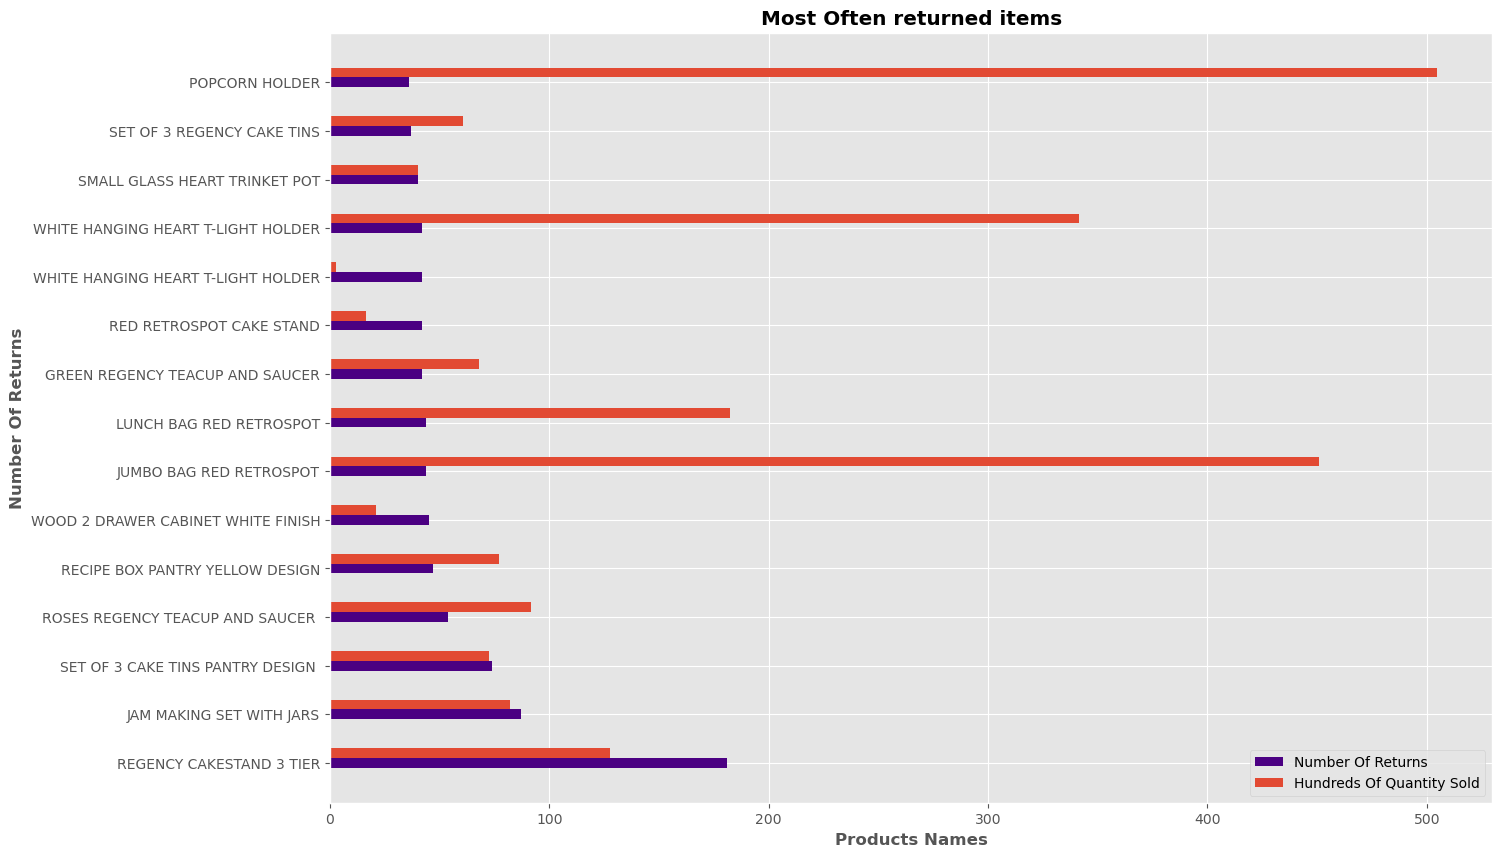

In [222]:
xpos = np.arange(len(returns_with_names['NumberOfReturns'][:15]))
bar_width = 0.2
plt.figure(figsize=(15,10))
plt.barh(xpos,width=merged_df['NumberOfReturns'][:15],color='indigo',height=bar_width,label='Number Of Returns')
plt.barh(xpos+0.2,width=merged_df['TotalQuantitySold'][:15]/100,height=bar_height,label='Hundreds Of Quantity Sold')
plt.yticks(xpos,([name for name in merged_df['Description'][:15]]))
plt.title('Most Often returned items',fontweight='bold')
plt.xlabel('Products Names',fontweight='bold')
plt.ylabel('Number Of Returns',fontweight='bold')
plt.legend()
plt.savefig('Most_often_returned_items.png',bbox_inches='tight')

In [188]:
merged_df = merged_df.sort_values(by='NumberOfReturns',ascending=False)

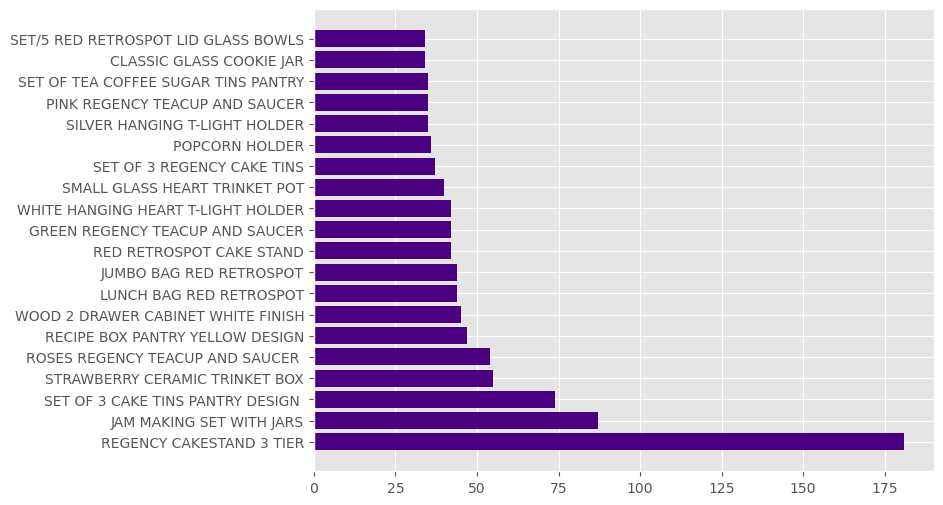

In [129]:
product_summary

,StockCode,TotalQuantitySold,TotalPrice,Description,UnitPrice
1308,22423,12747,160693.170,REGENCY CAKESTAND 3 TIER,12.750
2667,47566,17810,97058.300,PARTY BUNTING,4.950
3401,85123A,34160,95343.640,WHITE HANGING HEART T-LIGHT HOLDER,2.950
3381,85099B,45078,88045.370,JUMBO BAG RED RETROSPOT,2.080
1940,23084,26411,57184.690,RABBIT NIGHT LIGHT,2.080
...,...,...,...,...,...
3660,90084,1,0.850,PINK CRYSTAL GUITAR PHONE CHARM,0.850
475,21268,2,0.840,VINTAGE BLUE TINSEL REEL,0.420
2710,51014c,1,0.830,"FEATHER PEN,COAL BLACK",0.830
2918,84227,1,0.420,HEN HOUSE W CHICK IN NEST,0.420


In [122]:
orders[orders['StockCode']=='22423']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
848,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210,United Kingdom,175.20
907,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552,United Kingdom,25.50
1069,536525,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:54:00,12.75,14078,United Kingdom,25.50
1107,536528,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:17:00,12.75,15525,United Kingdom,12.75
1178,536530,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:21:00,12.75,17905,United Kingdom,12.75
...,...,...,...,...,...,...,...,...,...
496685,579693,22423,REGENCY CAKESTAND 3 TIER,2,2011-11-30 14:09:00,12.75,15712,United Kingdom,25.50
497103,579747,22423,REGENCY CAKESTAND 3 TIER,4,2011-11-30 14:40:00,12.75,12528,Germany,51.00
497524,579777,22423,REGENCY CAKESTAND 3 TIER,1,2011-11-30 15:13:00,24.96,0,United Kingdom,24.96
498412,579870,22423,REGENCY CAKESTAND 3 TIER,1,2011-11-30 16:47:00,12.75,12437,France,12.75


In [121]:
cancelled_orders_and_returns[cancelled_orders_and_returns['StockCode']=='S']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
14384,C537581,S,SAMPLES,1,2010-12-07 12:03:00,12.95,0,United Kingdom,12.95
14385,C537581,S,SAMPLES,1,2010-12-07 12:03:00,52.00,0,United Kingdom,52.00
96208,C544580,S,SAMPLES,1,2011-02-21 14:25:00,5.74,0,United Kingdom,5.74
96209,C544580,S,SAMPLES,1,2011-02-21 14:25:00,11.08,0,United Kingdom,11.08
96210,C544580,S,SAMPLES,1,2011-02-21 14:25:00,5.79,0,United Kingdom,5.79
...,...,...,...,...,...,...,...,...,...
386945,C570464,S,SAMPLES,1,2011-10-10 16:01:00,47.98,0,United Kingdom,47.98
411944,C572347,S,SAMPLES,1,2011-10-24 11:03:00,33.05,0,United Kingdom,33.05
478467,C577330,S,SAMPLES,1,2011-11-18 14:16:00,2.89,0,United Kingdom,2.89
478468,C577330,S,SAMPLES,1,2011-11-18 14:16:00,75.00,0,United Kingdom,75.00


In [ ]:
# countries which buy the most 

def create_country_orders_tuples(orders):
    country_order_counts = orders['Country'].value_counts()
    country_order_tuples = [(country, count) for country, count in country_order_counts.items() if (country !='Unspecified') and (country!= 'Channel Islands')]
    return country_order_tuples

def map_countries_with_codes(country_order_tuples):

    country_codes = {
        'United Kingdom': 'gb',
        'Germany': 'de',
        'France': 'fr',
        'EIRE': 'ie',
        'Spain': 'es',
        'Netherlands': 'nl',
        'Belgium': 'be',
        'Switzerland': 'ch',
        'Portugal': 'pt',
        'Australia': 'au',
        'Norway': 'no',
        'Italy': 'it',
        'Finland': 'fi',
        'Cyprus': 'cy',
        'Sweden': 'se',
        'Austria': 'at',
        'Denmark': 'dk',
        'Japan': 'jp',
        'Poland': 'pl',
        'Israel': 'il',
        'USA': 'us',
        'Hong Kong': 'hk',
        'Singapore': 'sg',
        'Iceland': 'is',
        'Canada': 'ca',
        'Greece': 'gr',
        'Malta': 'mt',
        'United Arab Emirates': 'ae',
        'European Community': 'eu',
        'RSA': 'za',
        'Lebanon': 'lb',
        'Lithuania': 'lt',
        'Brazil': 'br',
        'Czech Republic': 'cz',
        'Bahrain': 'bh',
        'Saudi Arabia': 'sa'
    }   
    country_order_tuples_with_codes = [
        (country_codes.get(country, country), order) for country, order in country_order_tuples
    ]  
    return country_order_tuples_with_codes

def create_interactive_map_and_save_as_file(countries,name):
    worldmap_chart = World()
    worldmap_chart.title = 'Number of orders based on Country'
    worldmap_chart.add('In 2010-2011',countries)
    worldmap_chart.render_to_file(name)

# values wich can't be showed on the map
unsepcifed_country_items = [('unspecified',443)]
channel_islands_items = [('Channel Islands',742)]
uk_items = [('UK',456006)]
# item-based
country_items_tuples = create_country_orders_tuples(orders)
country_items_tuples_with_codes = map_countries_with_codes(country_items_tuples)
country_items_tuples_with_codes.pop(0)

from pygal_maps_world.maps import World

create_interactive_map_and_save_as_file(country_items_tuples_with_codes,'countries_items_map.svg')


# order-based
unsepcifed_country_orders = [('unspecified',13)]
channel_islands_orders = [('Channel Islands',24)]
uk_orders = ['UK',16961]
country_order_tuples = create_country_orders_tuples(df_real_orders)
country_order_tuples_with_codes = map_countries_with_codes(country_order_tuples)
country_order_tuples_with_codes.pop(0)

create_interactive_map_and_save_as_file(country_order_tuples_with_codes,'countries_orders_map.svg')

481901.62

9350392.473000001

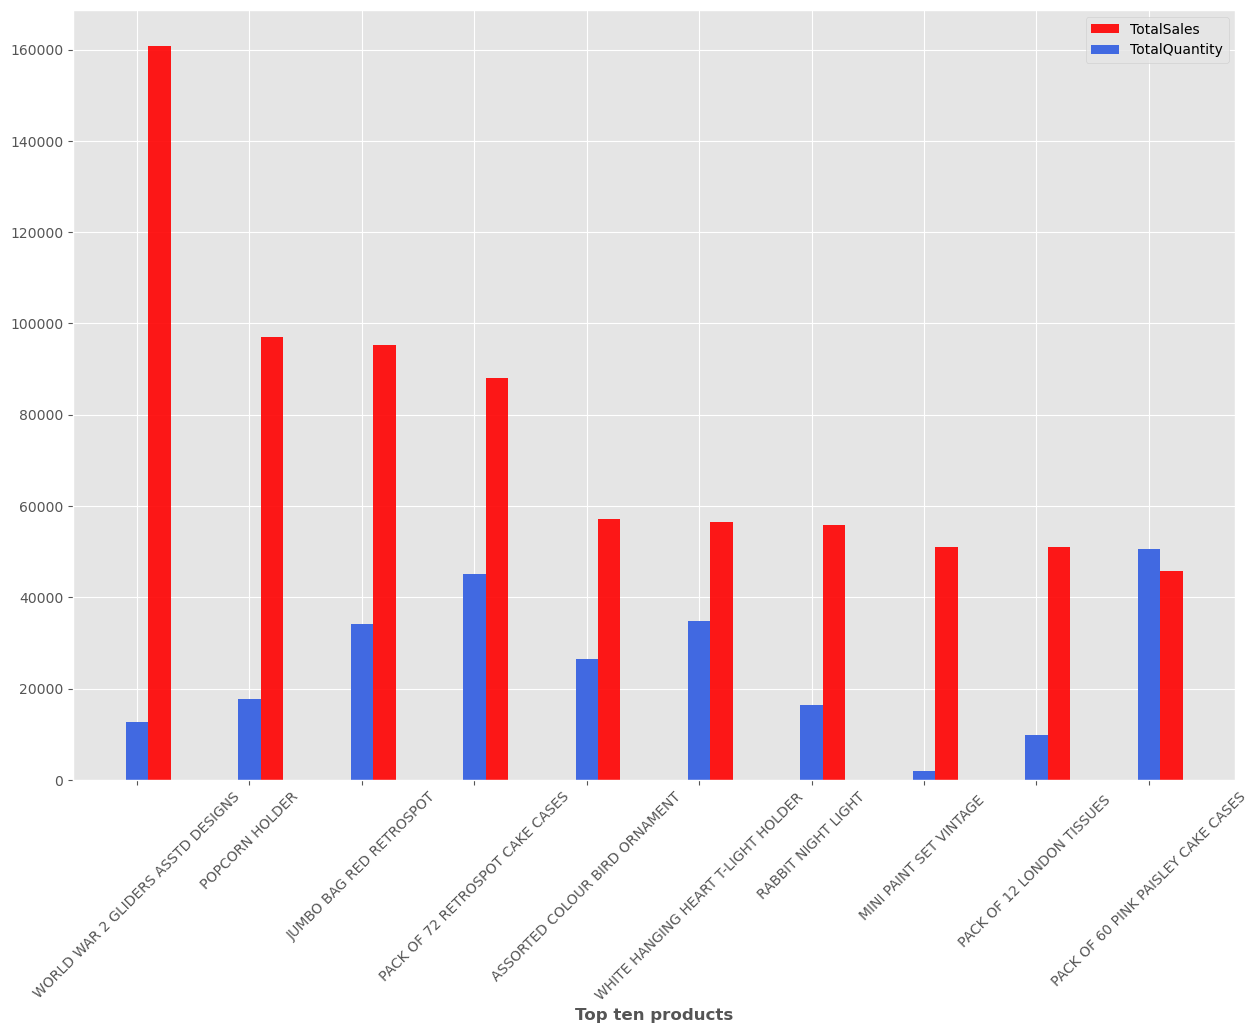

In [86]:
style.use('ggplot')
xpos = np.arange(len(top_10_total_amount_items['Description'][:10]))
barwidth=0.2
plt.figure(figsize=(15,10))
plt.bar(xpos +0.2, top_10_total_amount_items['TotalPrice'][:10],width=barwidth,color='red',label='TotalSales',alpha=0.9)
plt.bar(xpos, top_10_total_amount_items['TotalQuantitySold'][:10], width=barwidth,color='royalblue',label='TotalQuantity')
plt.xticks(xpos,([name for name in most_frequently_sold_items['Description'][:10]]),rotation=45)
plt.legend()
plt.xlabel('Top ten products',fontweight='bold'
plt.savefig('Top_amount_with_quantity.png',bbox_inches='tight')

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


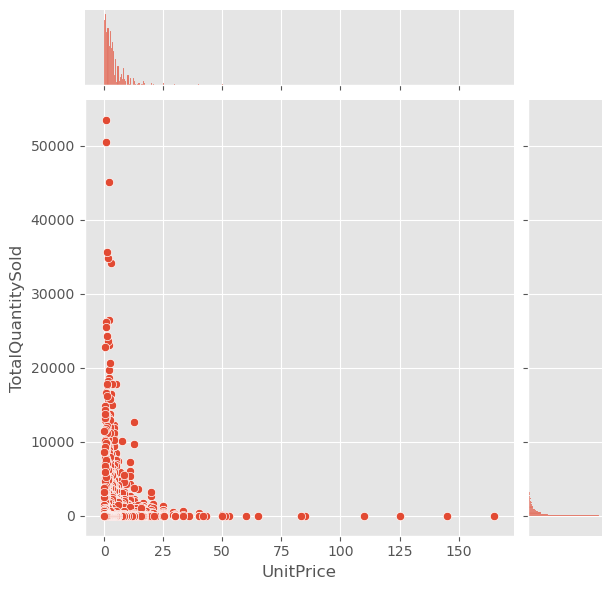

In [15]:
sns.jointplot('UnitPrice',y='TotalQuantitySold',data=product_summary)
plt.savefig('Distribution_prices_over_quantity',bbox_inches='tight')

In [195]:
orders.groupby(['StockCode'])['Quantity'].sum().sort_values(ascending=False)

StockCode
84077     53488
22197     50467
85099B    45078
21212     35600
84879     34897
          ...  
90187A        1
23609         1
23602         1
20860         1
m             1
Name: Quantity, Length: 3909, dtype: int32

In [12]:
merged_df['_merge'].value_counts()

left_only     523552
both            5906
right_only         0
Name: _merge, dtype: int64

In [63]:
def create_dataframe_with_sales_per_item():
    
    grouped = orders.groupby(['StockCode'])
    items_count = grouped['Quantity'].sum()
    product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
    product_summary = pd.DataFrame({
        'TotalQuantitySold': items_count,
        'TotalPrice': product_total_prices
    }).reset_index()
    stockCode_to_desc = orders.set_index('StockCode')['Description'].to_dict()


C:\Users\komputer\AppData\Local\Temp\ipykernel_16436\819847036.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  product_total_prices = grouped['Quantity', 'UnitPrice'].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


In [79]:
product_summary['Description'] = product_summary['StockCode'].map(stockCode_to_desc)

In [4]:
cancelled_orders_and_returns

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
1,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
2,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
3,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
4,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
9006,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536,France
9007,C580510,M,Manual,-1,2011-12-04 13:48:00,1.25,14456,United Kingdom
9008,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971,United Kingdom
9009,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490,United Kingdom


In [21]:
df_M_returns = df_M[df_M['Quantity']<0]

In [9]:
df_M.sort_values(by=['UnitPrice'],ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098,United Kingdom
173391,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,0,United Kingdom
268027,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448,United Kingdom
422375,C573079,M,Manual,-2,2011-10-27 14:15:00,4161.06,12536,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536,France
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536,France
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore
406404,C571750,M,Manual,-1,2011-10-19 11:16:00,3949.32,12744,Singapore
293842,C562647,M,Manual,-1,2011-08-08 12:56:00,3155.95,15502,United Kingdom


In [11]:
maska = cancelled_orders_and_returns['InvoiceNo'].str.startswith('C')==False
cancelled_orders_and_returns[maska]['Quantity'].value_counts()

-1       79
-2       58
-5       46
-3       39
-6       36
         ..
-116      1
-304      1
-272      1
-1206     1
-235      1
Name: Quantity, Length: 298, dtype: int64

In [4]:
quantity_stats = orders['Quantity'].describe()
unit_price_stats = orders['UnitPrice'].describe()
print("Quantity Statistics:")
print(quantity_stats)

print("\nUnitPrice Statistics:")
print(unit_price_stats)

Quantity Statistics:
count    497473.000000
mean         10.201709
std          36.749389
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max        4800.000000
Name: Quantity, dtype: float64

UnitPrice Statistics:
count    497473.000000
mean          3.258285
std           4.348408
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max         649.500000
Name: UnitPrice, dtype: float64


In [196]:
orders[:-1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
498610,579885,85114C,RED ENCHANTED FOREST PLACEMAT,6,2011-11-30 17:37:00,1.65,15444,United Kingdom,9.90
498611,579885,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2011-11-30 17:37:00,2.95,15444,United Kingdom,2.95
498612,579885,85159A,"BLACK TEA,COFFEE,SUGAR JARS",1,2011-11-30 17:37:00,1.95,15444,United Kingdom,1.95
498613,579885,85168B,BLACK BAROQUE CARRIAGE CLOCK,1,2011-11-30 17:37:00,9.95,15444,United Kingdom,9.95


In [29]:
orders.groupby('InvoiceNo')['FullPrice'].sum()

InvoiceNo
536365     139.12
536366      11.10
536367     278.73
536368      70.05
536369      17.85
           ...   
579868     328.32
579870     256.41
579872     278.82
579881     905.52
579885    1075.36
Name: FullPrice, Length: 18727, dtype: float64

In [36]:
orders[:9]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
5,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
6,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
8,536367,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047,United Kingdom,17.85


In [33]:
unique_orders

,InvoiceNo,Country,DiffrentItemsPerOrder,Quantity,CustomerID,InvoiceDate,FullPrice
0,536365,United Kingdom,7,40,17850,2010-12-01 08:26:00,139.12
1,536366,United Kingdom,1,6,17850,2010-12-01 08:28:00,11.10
2,536367,United Kingdom,12,83,13047,2010-12-01 08:34:00,278.73
3,536368,United Kingdom,4,15,13047,2010-12-01 08:34:00,70.05
4,536369,United Kingdom,1,3,13047,2010-12-01 08:35:00,17.85
...,...,...,...,...,...,...,...
18722,579868,United Kingdom,22,406,15544,2011-11-30 13:45:00,328.32
18723,579870,France,13,97,12437,2011-11-30 13:46:00,256.41
18724,579872,United Kingdom,17,239,14085,2011-11-30 13:48:00,278.82
18725,579881,Denmark,27,512,12429,2011-11-30 13:50:00,905.52


In [32]:
#unique_orders_for_customer
unique_orders.groupby('CustomerID')['InvoiceNo'].count().value_counts()

1       1551
2        807
3        510
4        386
5        223
6        168
7        131
8         93
9         60
11        51
10        47
12        40
13        26
14        21
15        20
19        16
17        15
16        13
20        11
18        10
21         9
23         7
25         6
28         6
26         5
27         4
24         4
37         3
22         3
30         3
35         3
29         2
43         2
55         2
47         2
87         2
32         2
34         2
50         1
31         1
44         1
39         1
183        1
120        1
1321       1
69         1
53         1
54         1
36         1
45         1
59         1
89         1
83         1
193        1
57         1
Name: InvoiceNo, dtype: int64

In [175]:
real_orders['CustomerID'].value_counts()

InvoiceNo  CustomerID
536365     17850           7
536366     17850           1
536367     13047          12
536368     13047           4
536369     13047           1
                        ... 
579868     15544          22
579870     12437          13
579872     14085          17
579881     12429          27
579885     15444         147
Name: CustomerID, Length: 18727, dtype: int64

In [12]:
unique_orders

,InvoiceNo,Country,DiffrentItemsPerOrder,Quantity,CustomerID,InvoiceDate
0,536365,United Kingdom,7,40,17850,2010-12-01 08:26:00
1,536366,United Kingdom,1,6,17850,2010-12-01 08:28:00
2,536367,United Kingdom,12,83,13047,2010-12-01 08:34:00
3,536368,United Kingdom,4,15,13047,2010-12-01 08:34:00
4,536369,United Kingdom,1,3,13047,2010-12-01 08:35:00
...,...,...,...,...,...,...
18722,579868,United Kingdom,22,406,15544,2011-11-30 13:45:00
18723,579870,France,13,97,12437,2011-11-30 13:46:00
18724,579872,United Kingdom,17,239,14085,2011-11-30 13:48:00
18725,579881,Denmark,27,512,12429,2011-11-30 13:50:00


Text(0.5, 1.0, 'Top ten customers by amount spent')

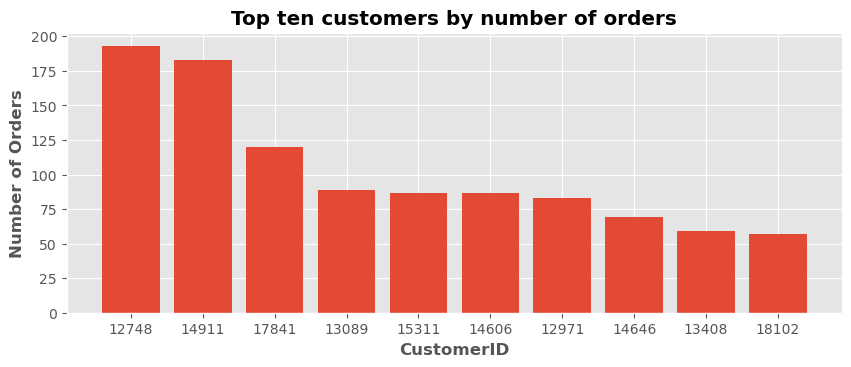

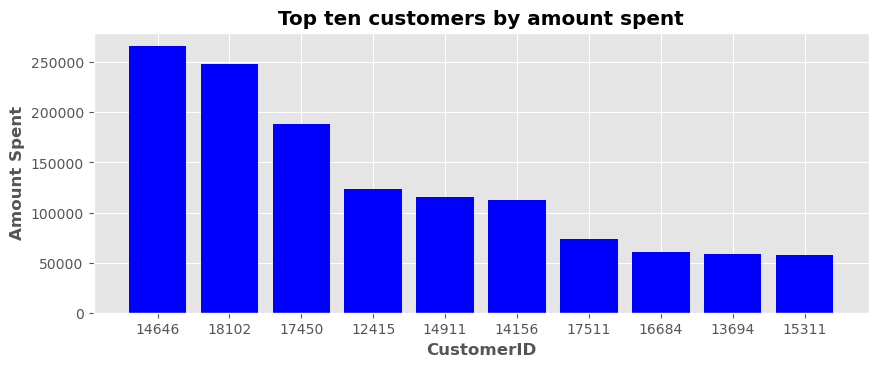

In [40]:
customers_by_amount_spent = unique_orders.groupby('CustomerID')['FullPrice'].sum().sort_values(ascending=False)

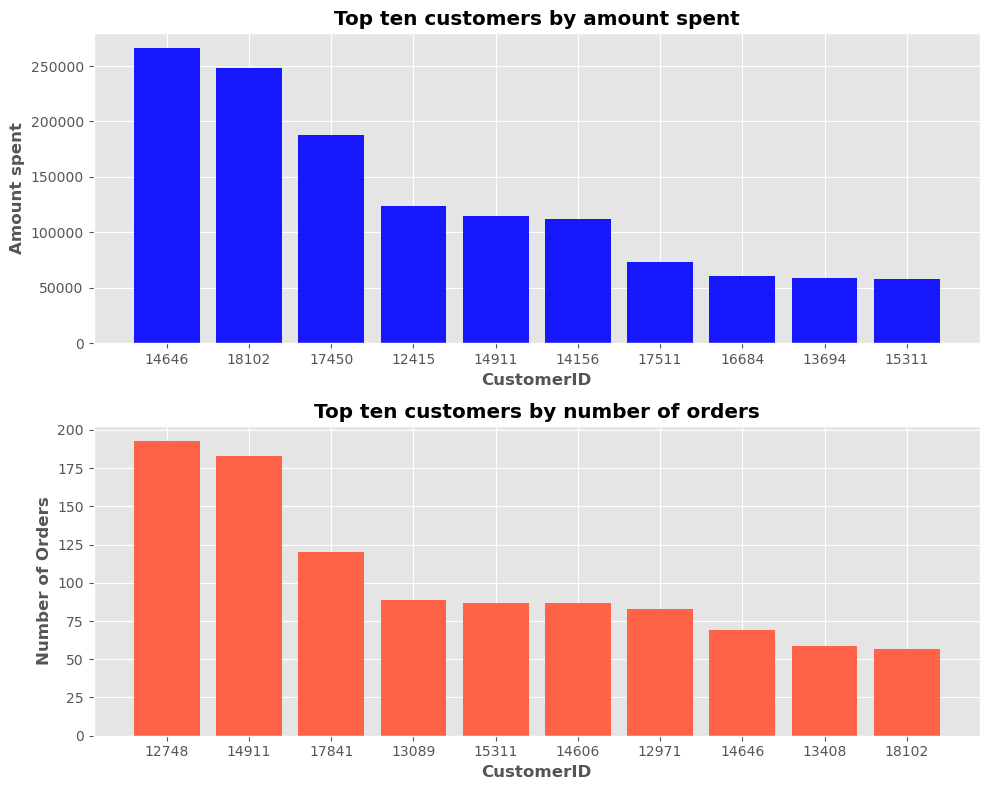

In [74]:
grouped_by_customer = orders.groupby('CustomerID')

In [75]:
grouped_by_customer
average_order_size_per_customer = grouped_by_customer['Quantity'].mean()

In [76]:
average_order_size_per_customer.sort_values()

CustomerID
16257       1.0
13452       1.0
12506       1.0
16349       1.0
16446       1.0
          ...  
14609    1756.5
16308    2000.0
16754    2140.0
18087    3906.0
13135    4300.0
Name: Quantity, Length: 4283, dtype: float64

In [81]:
orders[orders['CustomerID']==16308]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullPrice
126330,547519,16014,SMALL CHINESE STYLE SCISSOR,1000,2011-03-23 14:46:00,0.32,16308,United Kingdom,320.0
171124,552172,16014,SMALL CHINESE STYLE SCISSOR,2000,2011-05-06 13:03:00,0.32,16308,United Kingdom,640.0
299932,564272,16014,SMALL CHINESE STYLE SCISSOR,2000,2011-08-24 10:52:00,0.32,16308,United Kingdom,640.0
418008,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,2011-11-02 11:24:00,0.32,16308,United Kingdom,960.0


In [25]:
filtered_df[filtered_df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
233,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
234,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
235,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
537752,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom
537753,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
539014,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
539015,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315,United Kingdom
